In [71]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_auc_score, roc_curve, classification_report)
import warnings
warnings.filterwarnings('ignore')

1. Data Exploration:

In [72]:
# Load the Dataset
df=pd.read_csv('diabetes.csv')

In [73]:
# performing EDA
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [74]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [76]:
df.shape

(768, 9)

In [77]:
# Missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

 There are no missing values.

In [78]:
# Statistical summary
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


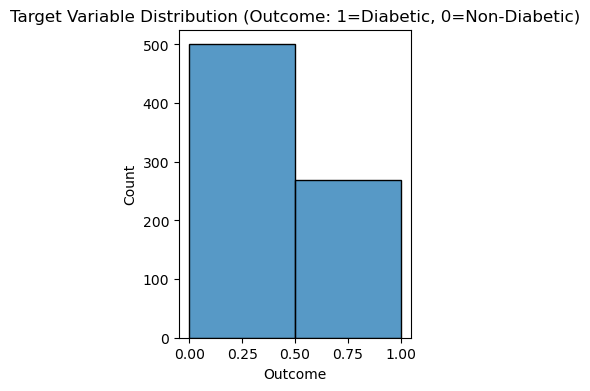

In [79]:
# Creating Visualizations
# Histogram
plt.figure(figsize=(3,4))
sns.histplot(df['Outcome'],bins=2 )
plt.title("Target Variable Distribution (Outcome: 1=Diabetic, 0=Non-Diabetic)")
plt.show()

<Axes: >

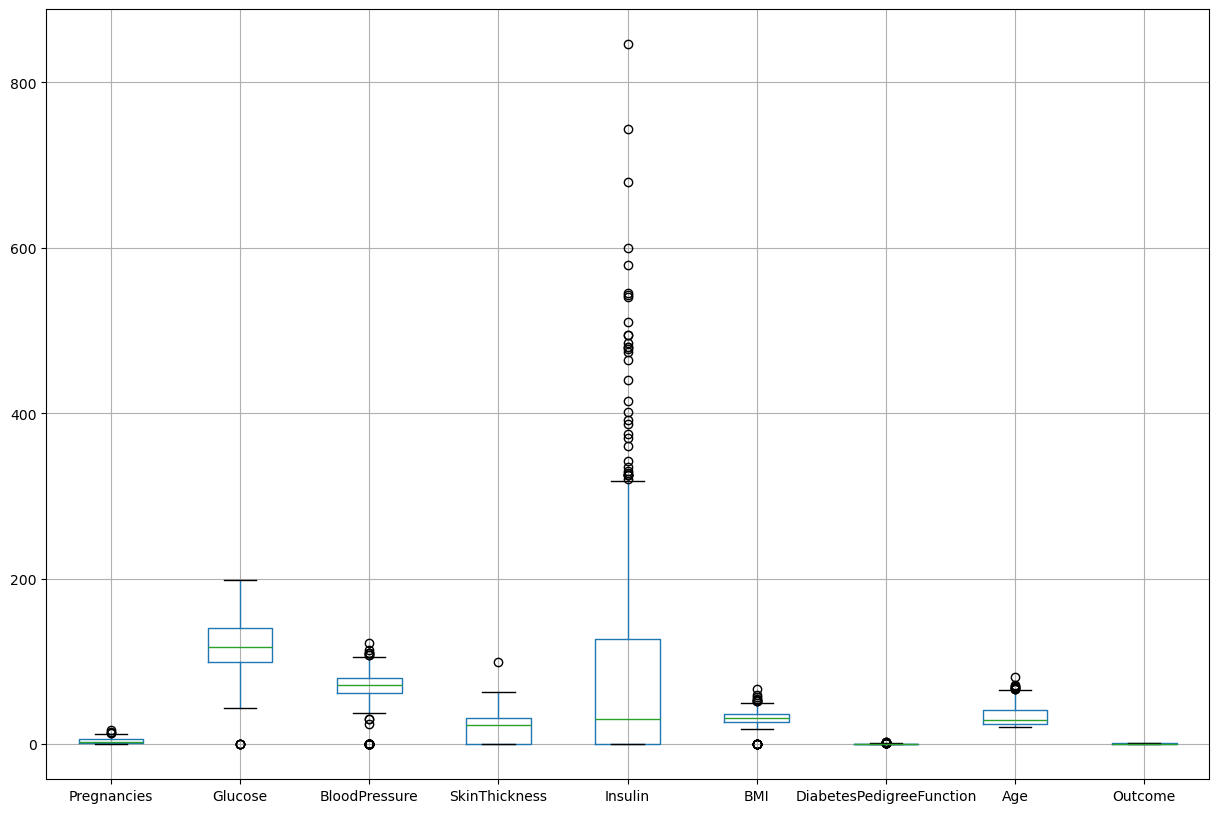

In [80]:
# Boxplot to check outliers
plt.figure(figsize=(15,10))
df.boxplot() # Before oulier Caping

In [81]:
### outlier capping
def outlier_capping(df,column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR= Q3-Q1
    lower_extreme= Q1-1.5*IQR
    upper_extreme= Q3+1.5*IQR
    df[column]= df[column].apply(lambda x: lower_extreme if x<lower_extreme else upper_extreme if x>upper_extreme else x)
for col in df.select_dtypes(['int','float']).columns:
    outlier_capping(df,col)

<Axes: >

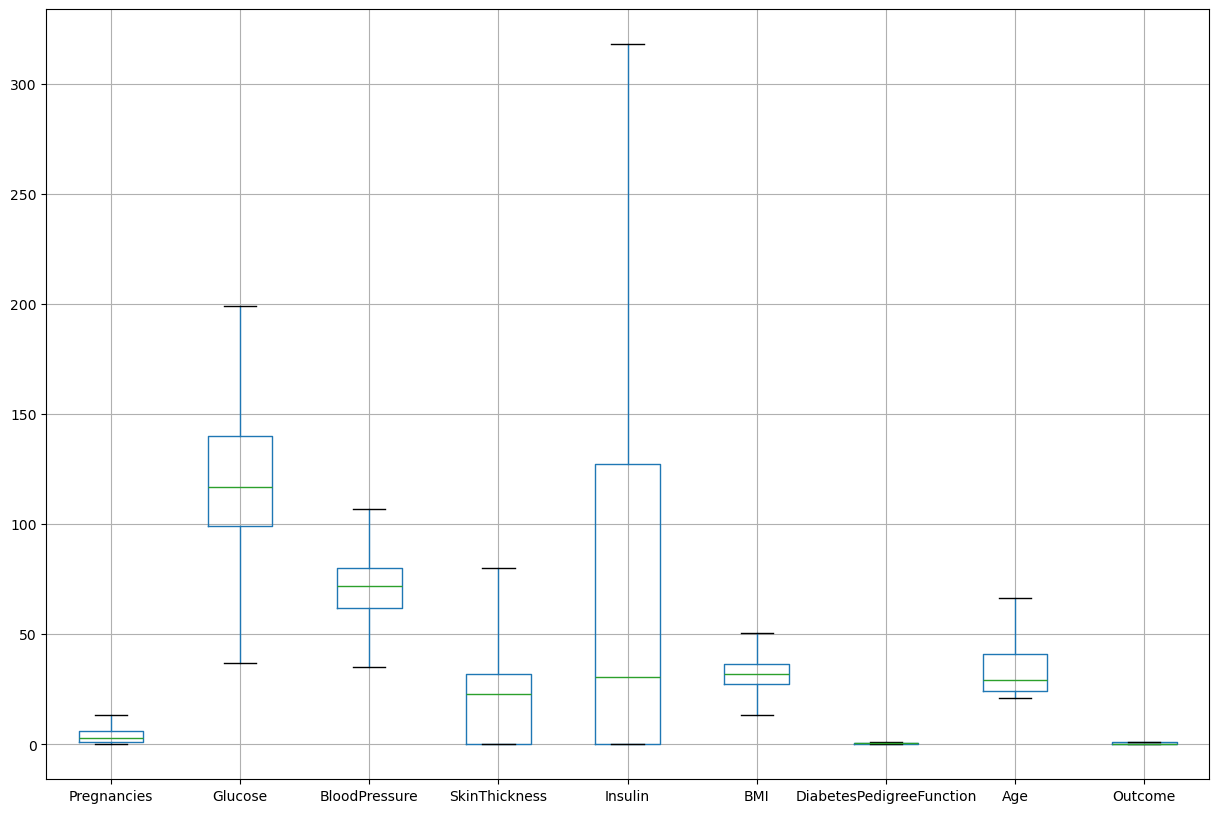

In [82]:
plt.figure(figsize=(15,10))
df.boxplot()  # After outliers capping

<Figure size 1500x1000 with 0 Axes>

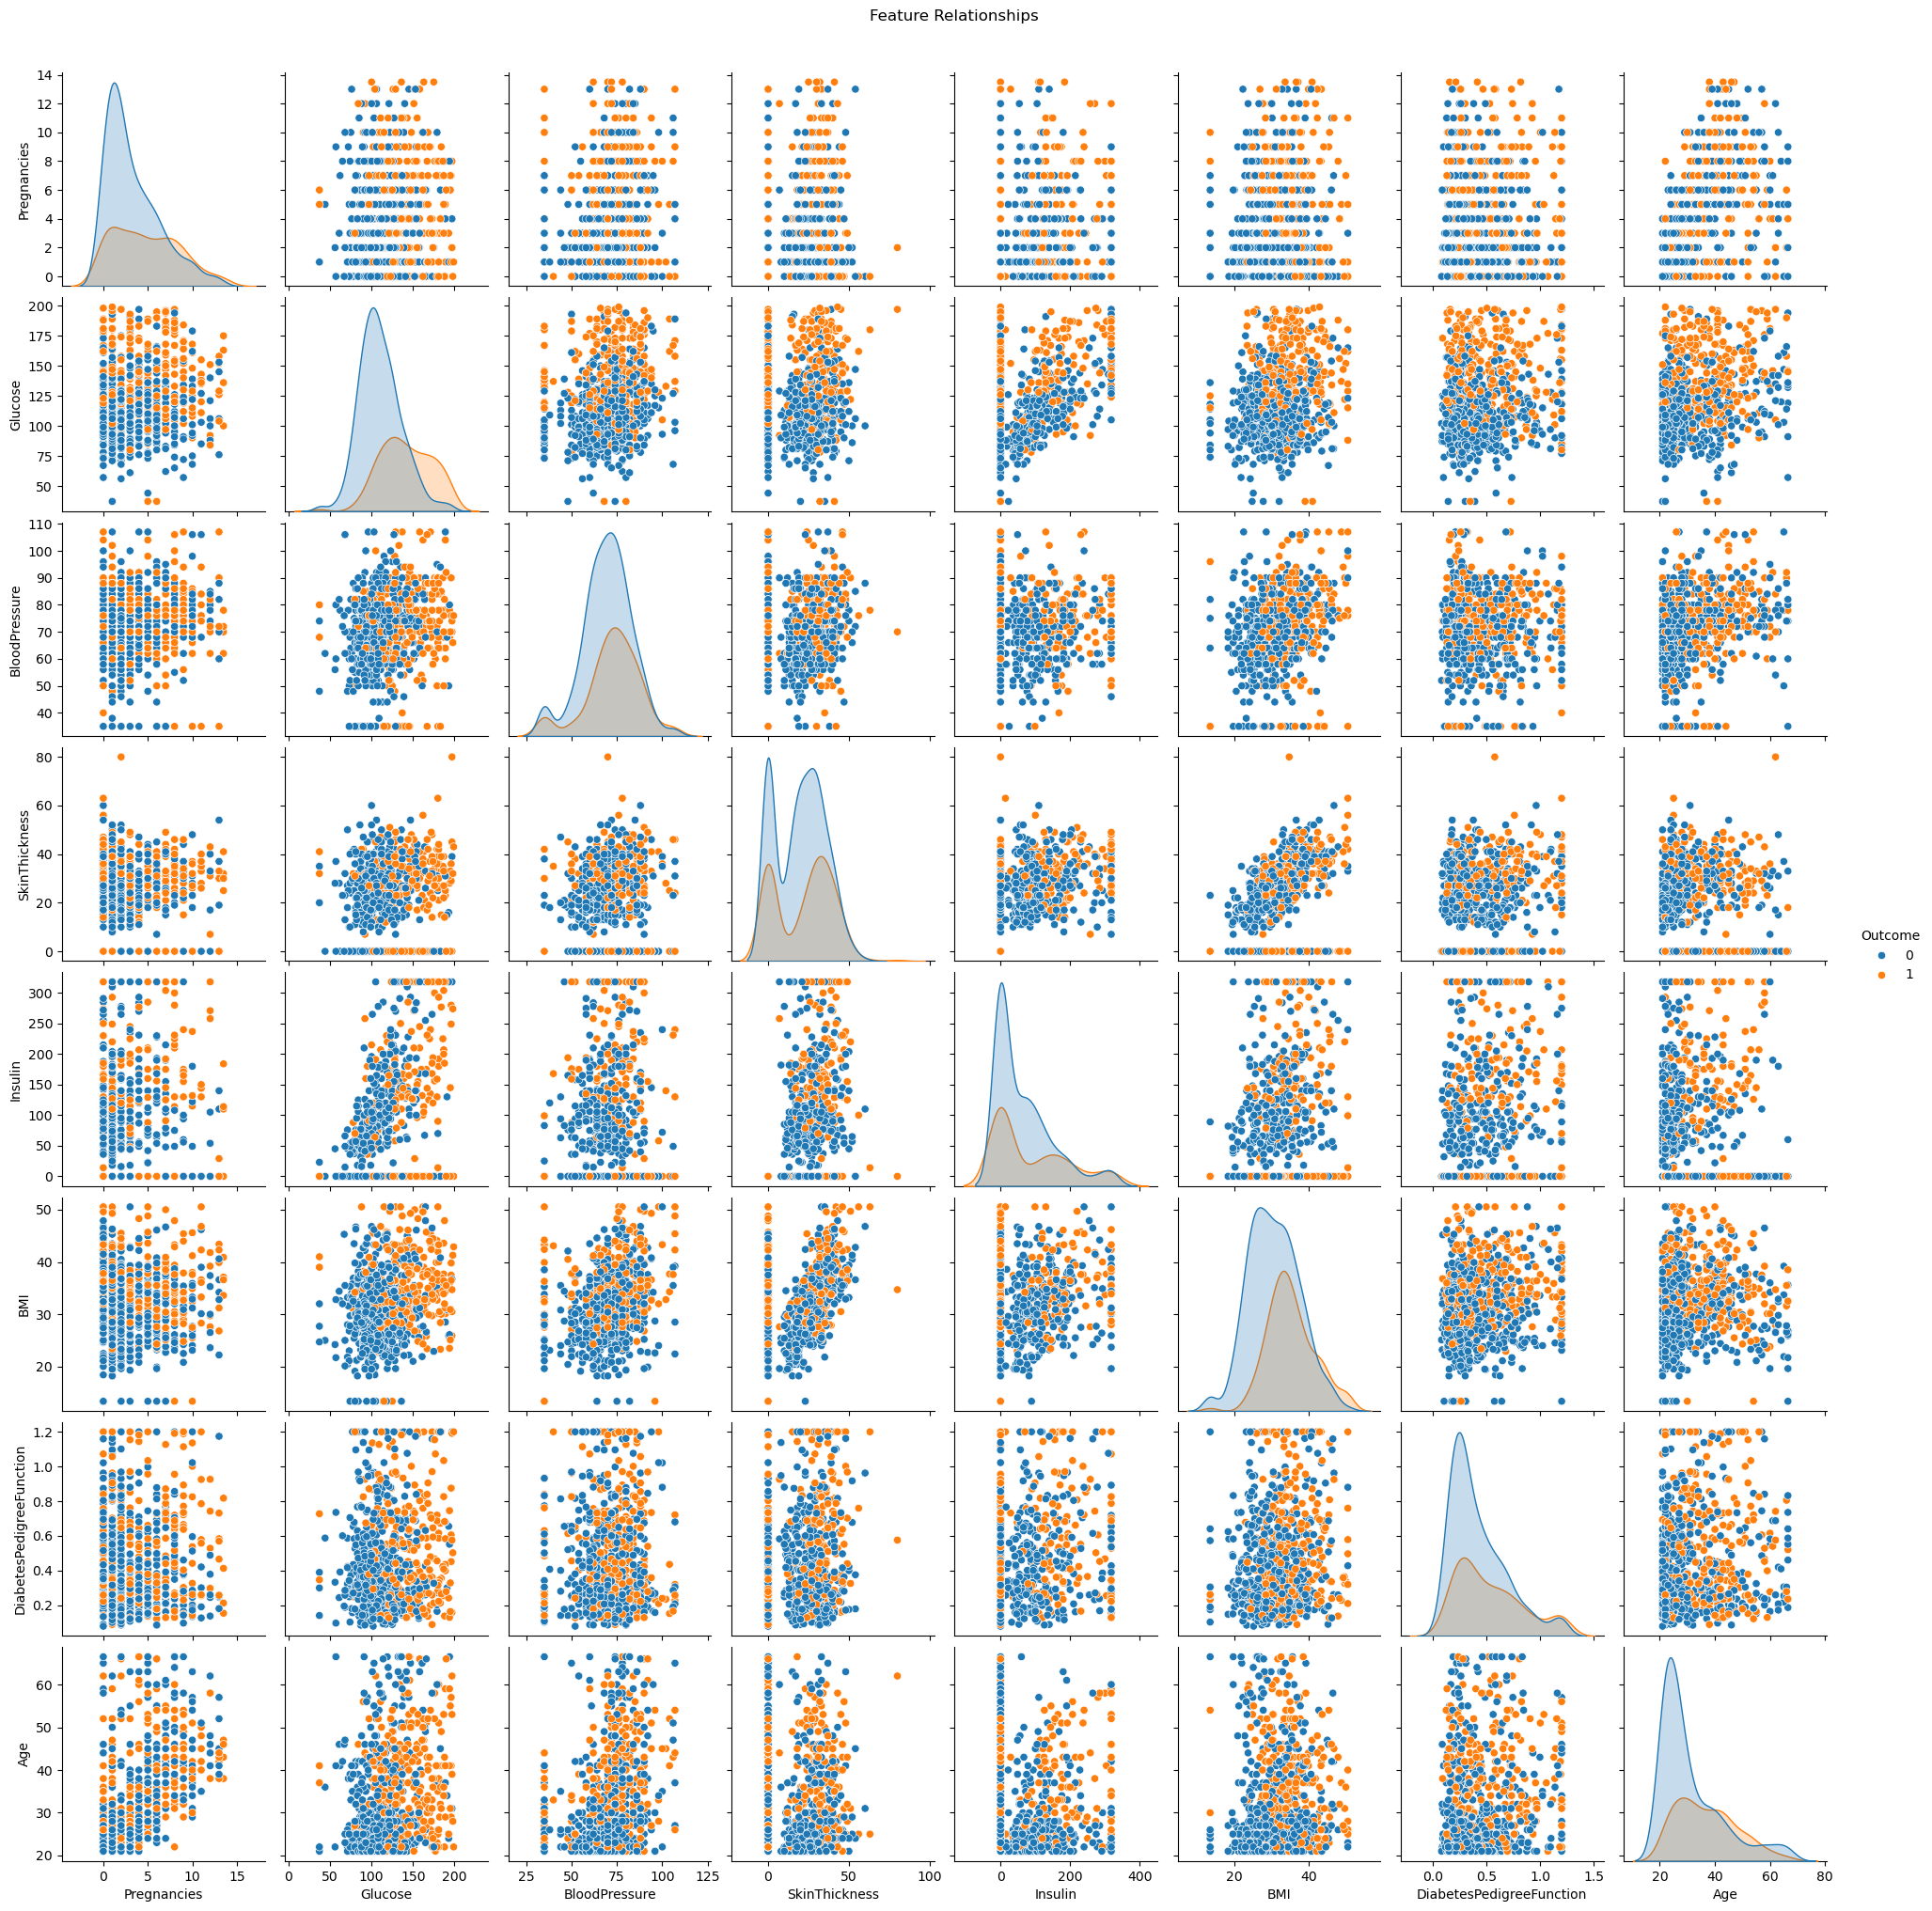

In [83]:
# Pairplot
plt.figure(figsize=(15,10))
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.suptitle("Feature Relationships", y=1.02)
plt.show()

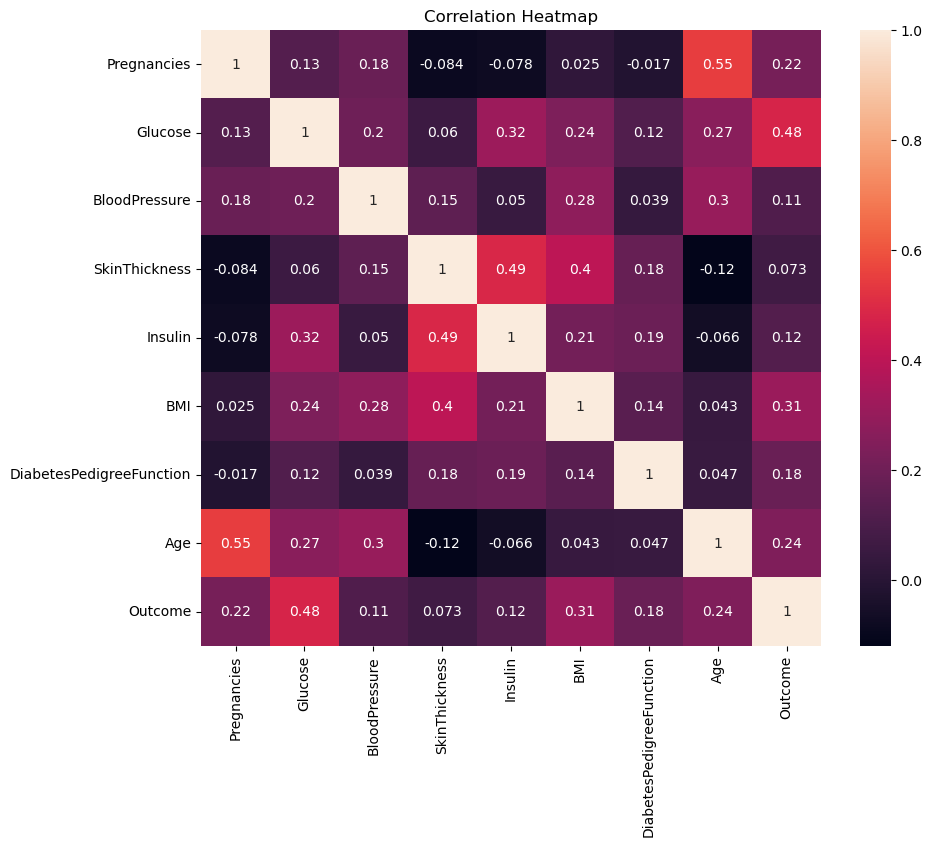

In [84]:
corr=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

2. Data Preprocessing:

In [85]:
# Handle missing values 
# In this dataset, there are 0 missing, but some 0s are invalid for some columns like Glucose, BP, etc.
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    df[col].replace(0, np.nan, inplace=True)
    df[col].fillna(df[col].median(), inplace=True)  # (fill missing value with median)

# check again for missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [86]:
# Encode categorical variables.
cat_col=df.select_dtypes(include=['object']).columns
cat_col

Index([], dtype='object')

This defines there are no categorical columns(objects).

In [87]:
df=pd.get_dummies(df,dtype=('int','float'))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1


3. Model Building:

* Build a logistic regression model using appropriate libraries 

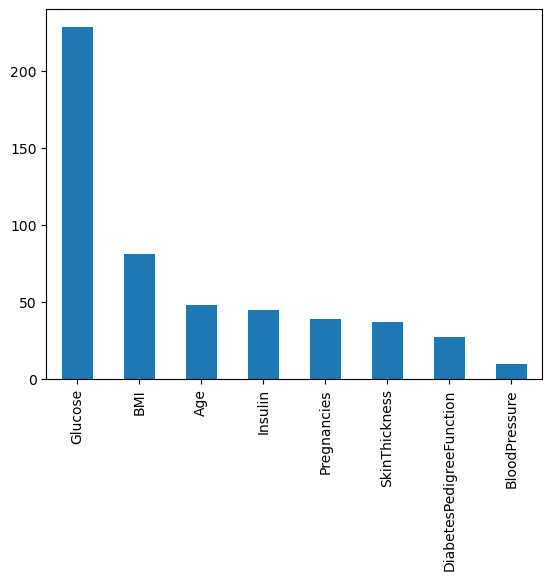

In [88]:
# Feature Selection
target= df['Outcome']
features= df.drop('Outcome', axis=1)

from sklearn.feature_selection import f_classif
f_class=f_classif(features,target)
pd.Series(f_class[0],index=features.columns).sort_values(ascending=False).plot(kind='bar')
plt.show()

b. Train the model using the training data.

In [89]:
# Train test split
x_train,x_test,y_train,y_test=train_test_split(features,target,train_size=0.8,random_state=100,stratify=target)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 8)
(154, 8)
(614,)
(154,)


In [90]:
#  Feature scaling
std_sca = StandardScaler()
X_train = std_sca.fit_transform(x_train)
X_test = std_sca.transform(x_test)

In [91]:
log_model=LogisticRegression()
log_model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [92]:
log_model.coef_

array([[ 0.42790096,  1.06858341, -0.22130512,  0.13096535, -0.09656481,
         0.6549201 ,  0.29527643,  0.14288569]])

In [93]:
log_model.intercept_

array([-0.87230562])

In [94]:
y_pred=log_model.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [95]:
y_prob =log_model.predict_proba(X_test)[:,1]
y_prob

array([0.13798678, 0.15281501, 0.93894201, 0.24276452, 0.74664407,
       0.48159524, 0.52239683, 0.03412161, 0.02540913, 0.52444869,
       0.18987516, 0.11665293, 0.32232262, 0.09441462, 0.7397897 ,
       0.79764736, 0.32962819, 0.3481856 , 0.07883361, 0.11352434,
       0.0454268 , 0.21301044, 0.17135527, 0.65623149, 0.08143721,
       0.17697578, 0.48793148, 0.02083575, 0.37019874, 0.64833257,
       0.61116292, 0.85168555, 0.69047806, 0.24724253, 0.13241005,
       0.65179367, 0.13068117, 0.10706335, 0.19629171, 0.25835749,
       0.04688265, 0.19800526, 0.49209498, 0.14452262, 0.29594851,
       0.05433866, 0.06852257, 0.38039405, 0.24190973, 0.69049078,
       0.45150777, 0.10878714, 0.18243835, 0.1853787 , 0.15877862,
       0.46447683, 0.0812248 , 0.47163582, 0.70536106, 0.16522296,
       0.7056174 , 0.32374496, 0.85998914, 0.63816554, 0.34024974,
       0.65732172, 0.29923796, 0.11517179, 0.61316138, 0.04515771,
       0.20952725, 0.24669756, 0.88704626, 0.48989768, 0.08511

4. Model Evaluation

a. Evaluate the performance of the model on the testing data using accuracy, precision, recall, F1-score, and ROC-AUC score.

In [96]:
print("Accuracy of the Logistic model is :", accuracy_score(y_test, y_pred))
print("Precision of the Logistic model is:", precision_score(y_test, y_pred))
print("Recall :", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Accuracy of the Logistic model is : 0.7857142857142857
Precision of the Logistic model is: 0.7692307692307693
Recall : 0.5555555555555556
F1 Score: 0.6451612903225806
ROC-AUC: 0.8505555555555555


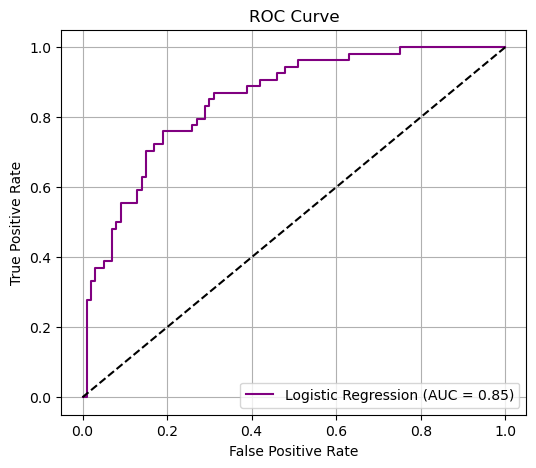

In [97]:
# Visualize the ROC curve.
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.2f})", color='purple')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

5. Interpretation:

In [98]:
# Interpret the coefficients of the logistic regression model.
coefficients = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': log_model.coef_[0]
})
coefficients['Impact'] = np.where(coefficients['Coefficient'] > 0, 'Increases Diabetes Risk', 'Decreases Diabetes Risk')

coefficients

,Feature,Coefficient,Impact
0,Pregnancies,0.427901,Increases Diabetes Risk
1,Glucose,1.068583,Increases Diabetes Risk
2,BloodPressure,-0.221305,Decreases Diabetes Risk
3,SkinThickness,0.130965,Increases Diabetes Risk
4,Insulin,-0.096565,Decreases Diabetes Risk
5,BMI,0.654920,Increases Diabetes Risk
6,DiabetesPedigreeFunction,0.295276,Increases Diabetes Risk
7,Age,0.142886,Increases Diabetes Risk


In [99]:
# Discuss Feature Significance
import statsmodels.api as sm

# Use training data only
X_const = sm.add_constant(X_train)   # add constant to scaled training data

logit_model = sm.Logit(y_train, X_const)   # align y_train with X_train
result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.469276
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                  0.2742
Time:                        15:08:27   Log-Likelihood:                -288.14
converged:                       True   LL-Null:                       -396.97
Covariance Type:            nonrobust   LLR p-value:                 1.194e-42
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8773      0.109     -8.053      0.000      -1.091      -0.664
x1             0.4373      0.

6. Deployment with Streamlit:

In [ ]:
# URL for the Streamlit deploy
# https://logisticregression-modeldeployment-ge3gi9ro9riuzphe2ydmqb.streamlit.app/

# Interview Questions:
1. What is the difference between precision and recall?
   
   Precision measures how many of the predicted positive samples are actually positive, while recall measures how many of the actual positive samples are correctly identified by the model.
In medical diagnosis, recall is often more important because missing a positive case (false negative) can be dangerous.

2. What is cross-validation, and why is it important in binary classification?
   
   Cross-validation is a technique that splits data into multiple training and testing sets to evaluate a model’s performance more reliably.
It prevents overfitting and ensures the model generalizes well to unseen data, which is crucial for balanced and imbalanced binary classification problems.


In [104]:
file='logr.pkl'

In [105]:
pickle.dump(log_model,open(file,'wb'))